In [32]:
%%capture
import os

import numpy as np
import pandas as pd
import pickle

from LabData.DataLoaders.SerumMetabolomicsLoader import SerumMetabolomicsLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.MedicalConditionLoader import MedicalConditionLoader
from LabData.DataLoaders.SubjectLoader import SubjectLoader

from LabUtils.addloglevels import sethandlers
from LabQueue.qp import qp, fakeqp

import Loaders
import config_local as cl
import LGBM
import ResultsAnalysis
import ShapCalc

In [3]:
%%capture

btld = Loaders.get_BloodTestsLoaderDF()



gmbdf = Loaders.get_GutMBLoader()


# ag = SubjectLoader().get_data(study_ids='10K', groupby_reg='first').df.loc[intersec][['gender','age']].dropna(how='any')
# btdf = btdf.reindex(ag.reindex)
# gmbdf = gmbdf.reindex(ag.reindex)

TypeError: 'method' object is not iterable

In [4]:
btdf = btld.df
btdf.index = btdf.index.get_level_values('RegistrationCode')

intersec = btdf.index.intersection(gmbdf.index)

btdf = btdf.loc[intersec]
gmbdf = gmbdf.loc[intersec]

In [52]:
possible_ages = [[i, i+9.9] for i in range(30, 80, 10)]
possible_gender = [0,1]
age_gender = []

for gender in possible_gender:
    for age_span in possible_ages:
        age = ag[ag['age'] <= age_span[1]]
        age = age[age['age'] >= age_span[0]]
        age.index = age.index.get_level_values('RegistrationCode')
        age_gender.append(age[age['gender'] == gender])
age_gender

[                  gender   age
 RegistrationCode              
 10K_1118741432       0.0  35.0
 10K_2086246041       0.0  36.0
 10K_2741177793       0.0  37.0
 10K_2945550451       0.0  31.0
 10K_3774163126       0.0  38.0
 10K_3817679743       0.0  38.0
 10K_5638147535       0.0  30.0
 10K_5708831646       0.0  33.0
 10K_6133989659       0.0  36.0
 10K_6574486945       0.0  31.0
 10K_6602192367       0.0  35.0
 10K_6856606284       0.0  38.0
 10K_8040311762       0.0  36.0
 10K_8400848306       0.0  34.0
 10K_8820878172       0.0  33.0
 10K_9283332645       0.0  39.0
 10K_9814829772       0.0  35.0,
                   gender   age
 RegistrationCode              
 10K_1001201093       0.0  42.0
 10K_1007474664       0.0  48.0
 10K_1012289523       0.0  44.0
 10K_1016331244       0.0  49.0
 10K_1020576262       0.0  42.0
 ...                  ...   ...
 10K_9970701406       0.0  48.0
 10K_9981509405       0.0  43.0
 10K_9982977445       0.0  46.0
 10K_9985445829       0.0  43.0
 10K_99

In [55]:
[age_gender[i].shape for i in range(len(age_gender))]

[(17, 2),
 (1429, 2),
 (1609, 2),
 (844, 2),
 (126, 2),
 (17, 2),
 (1472, 2),
 (1383, 2),
 (591, 2),
 (112, 2)]

In [69]:
n_pairs = 10
x = pd.DataFrame()
for i in range(len(age_gender)):
    participants = age_gender[i].index.to_list()
    if len(participants) > 20:
        participants = participants[0:20]
    x = pd.concat([x, btdf.loc[participants], gmbdf.loc[participants]], axis=0)
    # np.concatenate((btdf.loc[participants], gmbdf.loc[participants])), axis=1)
x

,bt__rbc_hyper_%,bt__luc_%,bt__platelet_large_cell_ratio,bt__magnesium,bt__non_hdl_cholesterol,bt__neutrophils_%,bt__bilirubin_direct,urine__sg,urine__albumin_creatinine_ratio,bt__egfr,...,fBin__86|gBin__420|sBin__610,fBin__86|gBin__422|sBin__613,fBin__86|gBin__422|sBin__614,fBin__86|gBin__422|sBin__616,fBin__86|gBin__423|sBin__618,fBin__86|gBin__423|sBin__620,fBin__86|gBin__429|sBin__631,fBin__88|gBin__434|sBin__637,fBin__94|gBin__448|sBin__654,fBin__97|gBin__462|sBin__678
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1118741432,NaN,NaN,NaN,NaN,136.0,44.9,NaN,NaN,NaN,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10K_2086246041,0.0,0.0,NaN,NaN,98.0,71.5,NaN,1.015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10K_2741177793,0.3,1.9,NaN,NaN,108.0,50.7,0.14,1.030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10K_2945550451,NaN,0.0,NaN,NaN,NaN,33.7,0.09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10K_3774163126,NaN,NaN,NaN,NaN,78.0,58.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_2518395218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.917774,-3.865264,-2.070325,-2.618369,-2.470084,-3.404929,-4.0,-3.446189,-4.000000,-4.0
10K_2575184963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.059165,-3.102189,-1.463304,-4.000000,-4.000000,-2.717190,-4.0,-4.000000,-4.000000,-4.0
10K_2596779247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.573421,-3.825494,-2.043256,-2.787571,-3.572744,-3.655945,-4.0,-4.000000,-3.183509,-4.0


In [5]:
tbd = btdf[:1000]
tgmb = gmbdf[:1000]


In [6]:
gmbbt = tgmb.merge(tbd, how='cross')

In [7]:
gmbbt

,fBin__100|gBin__474|sBin__695,fBin__100|gBin__477|sBin__698,fBin__100|gBin__483|sBin__709,fBin__102|gBin__490|sBin__721,fBin__104|gBin__493|sBin__730,fBin__104|gBin__494|sBin__731,fBin__104|gBin__498|sBin__736,fBin__108|gBin__515|sBin__767,fBin__108|gBin__525|sBin__778,fBin__108|gBin__531|sBin__787,...,bt__urea,bt__egfr_estimate,bt__albumin,bt__bilirubin_total,bt__lymphocytes_abs,bt__estradiol_e2,urine__glucose,bt__testosterone,bt__protein_total,bt__crp_wide_range
0,-4.000000,-4.000000,-4.0,-2.686309,-3.574415,-4.000000,-4.0,-2.032384,-4.000000,-2.669366,...,32.00,81.0,4.20,1.10,2.92,NaN,NaN,NaN,7.00,NaN
1,-4.000000,-4.000000,-4.0,-2.686309,-3.574415,-4.000000,-4.0,-2.032384,-4.000000,-2.669366,...,28.42,NaN,4.33,0.40,2.40,NaN,NaN,NaN,7.14,NaN
2,-4.000000,-4.000000,-4.0,-2.686309,-3.574415,-4.000000,-4.0,-2.032384,-4.000000,-2.669366,...,29.00,NaN,4.20,0.60,1.23,NaN,NaN,NaN,6.80,NaN
3,-4.000000,-4.000000,-4.0,-2.686309,-3.574415,-4.000000,-4.0,-2.032384,-4.000000,-2.669366,...,NaN,NaN,NaN,NaN,2.09,NaN,NaN,NaN,NaN,NaN
4,-4.000000,-4.000000,-4.0,-2.686309,-3.574415,-4.000000,-4.0,-2.032384,-4.000000,-2.669366,...,23.59,NaN,4.29,0.71,3.10,162.0,NaN,NaN,7.21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-1.828896,-2.559006,-4.0,-2.903308,-4.000000,-3.652095,-4.0,-4.000000,-3.300058,-4.000000,...,19.00,NaN,NaN,1.10,2.80,NaN,NaN,NaN,NaN,NaN
999996,-1.828896,-2.559006,-4.0,-2.903308,-4.000000,-3.652095,-4.0,-4.000000,-3.300058,-4.000000,...,38.00,NaN,3.95,0.60,2.58,NaN,-1.0,NaN,6.85,0.70
999997,-1.828896,-2.559006,-4.0,-2.903308,-4.000000,-3.652095,-4.0,-4.000000,-3.300058,-4.000000,...,40.00,NaN,4.80,0.60,1.99,734.0,-1.0,NaN,7.30,NaN
999998,-1.828896,-2.559006,-4.0,-2.903308,-4.000000,-3.652095,-4.0,-4.000000,-3.300058,-4.000000,...,22.00,NaN,3.97,0.31,2.40,NaN,NaN,NaN,7.12,0.33


In [33]:
y = np.eye(len(tbd)).flatten()
y = pd.Series(y,name='is_self')
x = gmbbt
out_dir = os.path.join(cl.PREDICTIONS_PATH, 'ContrasiveTrees')

Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


finished is_self at 17:34:59


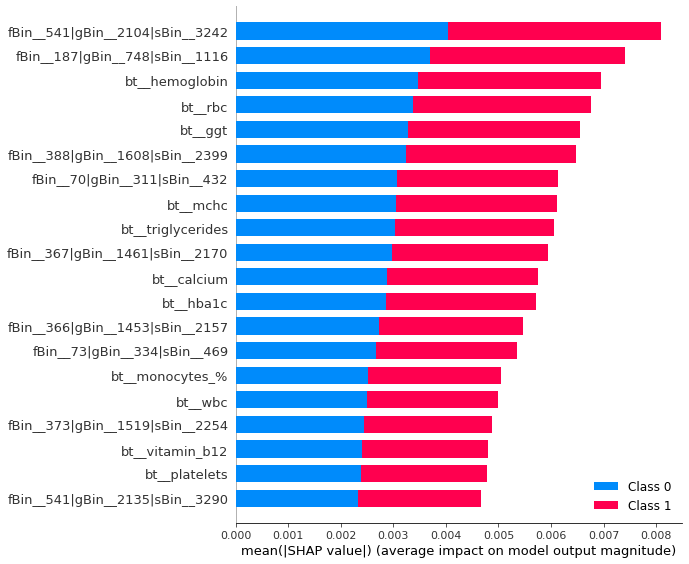

In [39]:
%%capture
results = LGBM.LGBMPredict(x, y, out_dir, do_permutations=False)

In [57]:
results[3]

,is_self
157105,0.0
374554,0.0
688694,0.0
265381,0.0
955415,0.0
...,...
957385,0.0
872294,0.0
295258,0.0
568161,0.0


In [82]:
import os
import time

import pickle
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import r2_score, explained_variance_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import pearsonr, spearmanr
import shap
import lightgbm as lgb
import statistics
import scipy.stats

import config_local as cl
from LabData import config_global as config

# LightGBM
lg_boosting_type = 'gbdt'
lg_objective = 'regression' # TODO change to classifier accordingly?
lg_metric = 'l2'
lg_learning_rate = 0.03
lg_num_leaves = 31
lg_max_depth = 4
lg_num_iterations = 2000
lg_min_data_in_leaf = 20
lg_feature_fraction = 0.1
lg_bagging_fraction = 0.7
lg_bagging_freq = 1
lg_lambda_l1 = 0
lg_early_stopping_round = None
lg_verbose = -1
lg_num_threads = 2
lg_silent = True

# LightGBM hyper parameter search
hyper_params_dict_lg = \
    {
        'boosting_type': ['gbdt'],
        'objective': ['regression'], #can be 'regression', 'binary', 'multiclass'....
        'metric': ['l2'],
        'learning_rate': [0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001],
        'num_leaves': range(2, 35),
        'max_depth': [-1, 2, 3, 4, 5, 10],
        'num_iterations': range(100, 2500, 50),
        'min_data_in_leaf': range(5, 100, 5),
        'feature_fraction': [i / 10. for i in range(2, 11)],  # [1] when using dummy variables
        'bagging_fraction': [i / 10. for i in range(4, 11)],
        'bagging_freq': [1],
        'lambda_l1': [0, 0.001, 0.005, 0.01],
        'early_stopping_round': [None],
        'verbose': [-1],
        'num_threads': [2],
        'silent': [True],
    }

n_permutations = 100


def is_classification(y):
    if (y.unique().shape[0] == 2) and ((type(y.unique().max()) == str) |
                                       (y.sort_values().unique() == np.array([0., 1.])).all()):
        return True
    return False


def fit_hyper_params_search(x, y, classification_problem, scale_pos_weight = None):
    if classification_problem:
        lgb_model = lgb.LGBMClassifier()
        hyper_params_dict_lg['objective'] = ['binary']
        if scale_pos_weight:
            hyper_params_dict_lg['scale_pos_weight'] = [scale_pos_weight]
    else:
        lgb_model = lgb.LGBMRegressor()

    rscv = RandomizedSearchCV(lgb_model, hyper_params_dict_lg)
    rscv.fit(x, y)
    predictor = rscv.best_estimator_
    model = predictor
    return model


def calc_shap(model, x):
    explainer = shap.TreeExplainer(model)
    x_shap = x
    shap_values = explainer.shap_values(x_shap)
    # shap_df = DataFrame(columns=x.columns, index=x_shap.index, data=shap_values[0])
    return explainer


def get_prediction(x: DataFrame, model: lgb.LGBMRegressor):
    return model.predict(x).ravel()


def evaluate_performance(y_pred, y_test, classification_problem):
    results_dict = {}
    if classification_problem:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        results_dict = {
            'prevalence': float(y_test.sum()) / y_test.shape[0],
            'AUC': metrics.auc(fpr, tpr),
            'Precision_Recall': metrics.auc(recall, precision)
        }
    else:
        results_dict = {
            'Coefficient_of_determination': r2_score(y_true=y_test, y_pred=y_pred),
            'explained_variance_score': explained_variance_score(y_true=y_test, y_pred=y_pred),
            'pearson_r': pearsonr(y_pred, y_test)[0],
            'pearson_p_value': pearsonr(y_pred, y_test)[1],
            'spearman_r': spearmanr(y_pred, y_test)[0],
            'spearman_p_value': spearmanr(y_pred, y_test)[1]
        }
    return results_dict


def save_files(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame,
               y_pred: pd.DataFrame, results_df: pd.DataFrame, model,
               perm_results: pd.DataFrame, is_signal: bool, out_dir, y_col):
    x_train.to_csv(os.path.join(out_dir, 'x_train.csv'))
    x_test.to_csv(os.path.join(out_dir, 'x_test.csv'))
    y_train.to_csv(os.path.join(out_dir, 'y_train.csv'))
    y_test.to_csv(os.path.join(out_dir, 'y_test.csv'))
    y_pred.to_csv(os.path.join(out_dir, 'y_pred.csv'))
    results_df.to_csv(os.path.join(out_dir, 'results.csv'))
    model.booster_.save_model('LGBM_model.txt')
    perm_results.to_csv(os.path.join(out_dir, f'Permutations_is_signal_{is_signal}'))

    # combined_dict = {
    #     'x_train': x_train,
    #     'x_test': x_test,
    #     'y_train': y_train,
    #     'y_test': y_test,
    #     'y_pred': y_pred,
    #     'model': model,
    #     'results_df': results_df,
    #     'perm_results': perm_results
    # }
    # combined_df = DataFrame(combined_dict, index=y_col)

    cl.save_pickle(x_train, out_dir, 'x_train.pickle')
    cl.save_pickle(x_test, out_dir, 'x_test.pickle')
    cl.save_pickle(y_train, out_dir, 'y_train.pickle')
    cl.save_pickle(y_test, out_dir, 'y_test.pickle')
    cl.save_pickle(y_pred, out_dir, 'y_pred.pickle')
    cl.save_pickle(results_df, out_dir, 'results.pickle')
    cl.save_pickle(perm_results, out_dir, f'Permutations_is_signal_{is_signal}.pickle')
    cl.save_pickle(model, out_dir, 'Model.pickle')

    # cl.save_pickle(combined_df, out_dir, 'combined_df.pickle')

    # model.booster_.save_model('LGBM_model.txt')


def get_sample_pvalue_out_of_data(data: list, sample: float):
    mu = statistics.mean(data)
    sigma = statistics.stdev(data)
    z = (sample - mu) / sigma
    p = scipy.stats.norm.sf(z)
    return mu, sigma, p


def draw_permutation_distribution(data: list, real_point: float, basepath: os.path):
    mu, sigma, p = get_sample_pvalue_out_of_data(data, real_point)
    sns.histplot(data)
    plt.annotate(f'pvalue={p}', xy=(0.05, 0.95), xycoords='axes fraction')
    plt.axline((real_point, 0), (real_point, 1), linewidth=1, color='r', label='Real Pearson_r')
    plt.savefig(os.path.join(basepath, 'permutation_histogram.png'), bbox_inches='tight')
    return


def permutations_test(x_train: DataFrame, x_test: DataFrame, y_train: DataFrame, y_test: DataFrame,
                      classification_problem: bool, real_results_df, basepath: os.path,
                      do_permutations: bool = True, scale_pos_weight=1):

    if not do_permutations:
        return None, None

    better_perm_score_count = 0
    is_signal = True
    perm_results = [] #{}
    if not classification_problem:
        metric = 'pearson_r'
    else:
        metric = 'AUC'

    if real_results_df[metric][0] < 0:
        is_signal = False
        return is_signal, perm_results
    for perm_iter in range(n_permutations):
        x_perm = x_train.copy()
        x_perm.index = np.random.permutation(x_perm.index)
        x_perm = x_perm.sample(frac=1)
        results_dict = train_model(x_perm, x_test, y_train, y_test, classification_problem=classification_problem,
                                   is_permuted=True, scale_pos_weight=scale_pos_weight)
        perm_results.append(results_dict[metric])
        # for k, v in results_dict.items():
        #     if perm_iter == 0:
        #         perm_results[k] = [v]
        #     else:
        #         perm_results[k].append(v)
        if real_results_df[metric][0] < results_dict[metric]:
            better_perm_score_count = better_perm_score_count + 1
        # if perm_iter > 0
        #     mu, sigma, p = get_sample_pvalue_out_of_data(perm_results, real_results_df[metric][0])
        #     sns.histplot(perm_results)
        #     plt.annotate(f'pvalue={p}', xy=(0.05, 0.95), xycoords='axes fraction')
        #     plt.show()
        if perm_iter == 4 or perm_iter == 9:
            if better_perm_score_count >= 3:
                is_signal = False
                # draw_permutation_distribution(perm_results, real_results_df[metric][0], basepath=basepath)
                return is_signal, perm_results
        if perm_iter == 99:
            if better_perm_score_count >= 5:
                is_signal = False
                # draw_permutation_distribution(perm_results, real_results_df[metric][0], basepath=basepath)
                return is_signal, perm_results
        if perm_iter >= 99:
            if better_perm_score_count/perm_iter > 0.06:
                is_signal = False
                return is_signal, perm_results
    # draw_permutation_distribution(perm_results, real_results_df[metric][0], basepath=basepath)
    return is_signal, perm_results


def train_model(x_train: DataFrame, x_test: DataFrame, y_train: DataFrame, y_test: DataFrame,
                classification_problem: bool, is_permuted: bool = False, scale_pos_weight = None):
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model = fit_hyper_params_search(x_train, y_train, classification_problem, scale_pos_weight=scale_pos_weight)
    y_pred = get_prediction(x_test, model)
    results_dict = evaluate_performance(y_pred, y_test, classification_problem)

    if is_permuted:
        return results_dict

    return y_pred, model, results_dict


def LGBMPredict(x: DataFrame, y: DataFrame, base_path: os.path, do_permutations: bool = True, scale_pos_weight = 1000):
    # base_path = "/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/AG_to_ABI"
    out_dir = os.path.join(base_path, y.name)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    os.chdir(out_dir)
    # with qp(jobname='Gal_LGBM', q=['himem7.q'], _mem_def=str(2) + 'G',
    #         _trds_def=2, max_u=650) as q:
    #     q.startpermanentrun()
    classification_problem = is_classification(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    # model = fit_hyper_params_search(x_train, y_train, classification_problem)
    # model.booster_.save_model('LGBM_model.txt')

    # y_pred = get_prediction(x_test, model)
    # results_dict = evaluate_performance(y_pred, y_test, classification_problem)
    y_pred, model, results_dict =\
        train_model(x_train, x_test, y_train, y_test, classification_problem=classification_problem, scale_pos_weight=scale_pos_weight)
    y_train = pd.DataFrame(y_train, columns=[y.name], index=x_train.index)
    y_test = pd.DataFrame(y_test, columns=[y.name], index=x_test.index)
    y_pred = pd.DataFrame(y_pred, columns=[y.name], index=x_test.index)
    result_df = pd.DataFrame(results_dict, index=[y.name])
    if not do_permutations:
        is_signal = None
        permutations_results = None
    else:
        is_signal, permutations_results = permutations_test(x_train, x_test, y_train, y_test,
                                                        classification_problem=classification_problem,
                                                        real_results_df=result_df, basepath=out_dir,
                                                        do_permutations=do_permutations, scale_pos_weight=scale_pos_weight)
    perm_df = pd.DataFrame(permutations_results, columns=[y.name])
    explainer = calc_shap(model, x_test)


    # result_df.to_csv(os.path.join(out_dir, 'results.csv'))
    save_files(x_train, x_test, y_train, y_test, y_pred, result_df, model, perm_df, is_signal, out_dir, y.name)
    plt.clf()
    shap.summary_plot(explainer.shap_values(x_test), x_test, show=False)
    plt.savefig('summary_plot.png', bbox_inches='tight')



    print(f'finished {y.name} at {time.strftime("%H:%M:%S", time.localtime())}')
    return x_train, x_test, y_train, y_test, y_pred, model, results_dict, permutations_results, is_signal



In [83]:
%%capture

results_unbalanced = LGBMPredict(x, y, out_dir, do_permutations=False, scale_pos_weight=1000)

In [100]:
print(f'number of is_self in test set is {results_unbalanced[3].sum()}, and number of is_self in predicted set is {results_unbalanced[4].sum()}')

number of is_self in test set isis_self    196.0
dtype: float64, and number of is_self in predicted set is is_self    0.0
dtype: float64


In [71]:
out_dir

'/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/ContrasiveTrees'

In [70]:
results_unbalanced[6]

{'prevalence': 0.00098, 'AUC': 0.5, 'Precision_Recall': 0.50049}